In [314]:
import numpy as np
import math
from matplotlib import pyplot as plt
import scipy.stats as sct

from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import weibull_min
from scipy.stats import poisson

from sklearn import linear_model

a)

Using the first 3 parts of taylor series expansion to compute expectation for control variate:

$e^{\frac{X}{2}} = 1 + \frac{X}{2} + \frac{X^2}{8} + O(X^3)$

$E[X] + \frac{E[X^2]}{2} + \frac{E[X^3]}{8}$

$ \frac{\Gamma(\frac{1}{2})}{2} + \frac{\Gamma(2)}{2} + \frac{\Gamma(\frac{1}{2})}{2} = \frac{4+7\pi}{8}$

b)

Setting $g(t) = te^{-\frac{t}{3}}$ we can compute the expectation for control variate:

$E[g(t)] = \int_0^{\infty}te^{-\frac{t}{3}}e^{-t} = \frac{9}{16}$

In [295]:
#c

def blop(CV, beta, epsilon, delta, burn_in):  
    if CV == 'a':
        def g(z):
            return 1 + z/2 + (z**2)/8
        EZ = (4+7*np.pi)/8
    else:
        def g(z):
            return z*np.exp(1)**(-z/3)
        EZ = 9/16

    ## Do the experiment
    # experiment variables
    z = sct.norm.ppf( 1 - delta/2 )  # 1 - delta/2 quantile of N(0, 1)
    confidence_interval = [-np.inf, np.inf] #start with an infinity confident interval
    running_mean = np.array([0, 0])    # first is null estimator, second corresponds to using control covariate
    running_2moment = np.array([0, 0])     # same as above
    N = 0     #count of number of path sampled
    Max_expriment = 50000

    CIs = np.zeros((2, Max_expriment))

    while (N < burn_in or confidence_interval[1] >= epsilon) and N < Max_expriment:
        Z = weibull_min.rvs(2)
        W0 = Z*(np.exp(1)**(Z/2))
        W = np.array([W0, W0 - (beta * (g(Z) - EZ))])
        
        running_mean = (running_mean * N + W) / (N + 1)
        running_2moment = (running_2moment * N + np.power(W, 2)) / (N + 1)
        sample_std = np.sqrt(running_2moment - np.power(running_mean, 2))
        N = N + 1
        confidence_interval = z * sample_std / (math.sqrt(N))
        CIs[:,N-1] = confidence_interval

    print('Generate', N , 'sample paths \n')
    n_range = np.arange(burn_in, N)
    plt.plot(n_range, CIs[0,n_range],  label='without cv')
    plt.plot(n_range, CIs[1,n_range], label='with cv')
    plt.legend(loc='upper right')
    plt.show()

    return running_mean

Generate 1441 sample paths 



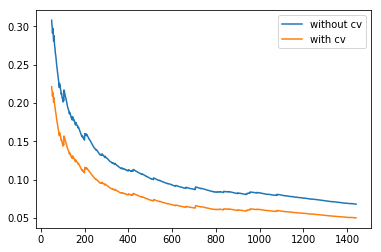

array([ 1.61640606,  3.29390244])

In [324]:
#using control variate from part a

blop('a', 1, .05, .05, 50)

Generate 1941 sample paths 



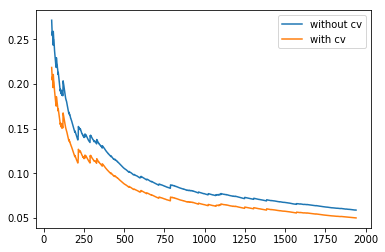

array([ 1.59012642,  1.54162987])

In [301]:
#using control variate from part b

blop('b', 1, .05, .05, 50)

a)

w/ $Cov(Y, X_1) > 0$ and $Cov(Y, X_2) > 0$

$V(W) = V(Y) + \beta_1^2V(X_1 - \alpha_1)+ \beta_2^2V(X_2 - \alpha_2) - 2\beta_1cov(Y,X_1-\alpha_1)- 2\beta_2cov(Y,X_2-\alpha_2) + 2\beta_1\beta_2cov[(Y,X_1-\alpha_1),cov(Y,X_2-\alpha_2)]$

$=V(Y) + \beta_1^2V(X_1)+ \beta_2^2V(X_2)- 2\beta_1cov(Y,X_1)+ 2\beta_1\beta_2cov(X_1,X_2)$

we need $Var(X_1) = Var(X_2)$ and $cov(Y,X_1) = cov(Y,X_2)$

so if we set $-\beta_1 = \beta_2$

$V(W) = V(Y) + \beta_1^2V(X_1) + 2\beta_1\beta_2cov(X_1,X_2)$

$= V(Y) + \beta_1^2V(X_1) + 2\beta_1^2cov(X_1,X_2)$

so $\beta_1 = -\sqrt{\frac{V(Y)}{2cov(X_1,X_2)-2Y(X_1)}}$

and $\beta_2 = -\beta_1$

b)

$=V(Y) + \beta_1^2V(X_1)+ \beta_2^2V(X_2)- 2\beta_1cov(Y,X_1)+ 2\beta_1\beta_2cov(X_1,X_2)$

$\frac{\partial V(W)}{\partial \beta_1} =  2\beta_1V(X_1) - 2cov(Y,X_1) + 2\beta_2cov(Y,X_2)$

$\frac{\partial V(W)}{\partial \beta_2} =  2\beta_2V(X_2) - 2cov(Y,X_2) + 2\beta_1cov(Y,X_1)$

a)

We model $Y = \sum_{i=1}^N X_i$ where $N \sim Pois(100)$ and $X \sim Exp(100)$

Then we can compute the probability by modeling the expectation $\alpha = P(Y>b) = E[I(Y > b)]$
where $b = 11,960$

In [315]:
def Y_sampler(b, pois_lam, exp_lam, n):
    claims = np.asarray([sum(expon.rvs(exp_lam,size=poisson.rvs(pois_lam))) for i in range(n)])
    return len(claims[claims>b])/len(claims)

In [316]:
Y_sampler(11960, 100, 100, 10000)

0.0331

In [317]:
Y_sampler(11960, 100, 100, 100000)

0.03522

In [318]:
Y_sampler(11960, 100, 100, 1000000)

0.034949

b)

In [321]:
def strat(delta, N):
    Lambda = 100
    Stratas = [i for i in range(90,111)]
    M = len(Stratas)

    ps = np.zeros(M)
    Ns = np.zeros(M)
    ps[0] = poisson.cdf(Stratas[0], Lambda)
    Ns[0] = round(ps[0] * N)
    for i in range(1, M-1):
        ps[i] = poisson.pmf(Stratas[i], Lambda)
        Ns[i] = round(ps[i] * N)
    ps[-1] = 1 - poisson.cdf(Stratas[-2], Lambda)
    Ns[-1] = N - np.sum(Ns)

    res = np.zeros(M)
    # first strata
    interval = np.arange(0,Stratas[0]+1)
    pd_number_of_arrival = poisson.pmf(interval, Lambda)
    pd_number_of_arrival = pd_number_of_arrival/(np.sum(pd_number_of_arrival))
    num_arrivals = np.random.choice(interval, int(Ns[0]), p=pd_number_of_arrival)

    Y = np.asarray([sum(expon.rvs(100, size=i)) for i in num_arrivals])
    res[0] = len(Y[Y>11960])/len(Y)
    
    # middle stratas
    for i in range(1, M-1):
        num_arrivals = (Stratas[i] * np.ones(int(Ns[i])))
        Y = np.asarray([sum(expon.rvs(100, size=i)) for i in num_arrivals.astype(int)])
        res[i] = len(Y[Y>11960])/len(Y)

    # last strata
    num_arrivals = np.random.poisson(Lambda, int(Ns[-1]))
    Y = np.asarray([sum(expon.rvs(100, size=i)) for i in num_arrivals])
    res[-1] = len(Y[Y>11960])/len(Y)

    w = res/sum(res)

    estimate = np.inner(w, res)
    half_interval = norm.ppf(1 - delta/2) * np.sqrt(np.var(res)/ np.sqrt(N))
    CI = [estimate - half_interval, estimate + half_interval]
    return estimate, CI, res

In [328]:
a,b,c = strat(.05, 10000)
print('P(Y > b): ',a,'\n')
print('95% CI: ',b)

P(Y > b):  0.0352319436289 

95% CI:  [0.033761391593697537, 0.036702495664082846]


In [227]:
1-norm.cdf(7,0,2)**4

0.00093019166876484594

In [18]:
def estimator(Z1, Z2, Z3, Z4):
    return max(Z1 + Z2, Z3  + Z4, Z1 + Z4, Z2 + Z3)

In [151]:
#initial test to see if it's actually possible to get non-zero probability

n = 1000000

test = np.zeros(n)
for i in range(n):
    x1, x2, x3, x4 = np.array_split(norm.rvs(0,1,4),4)
    test[i] = estimator(x1, x2, x3, x4)[0]
print('P(max(X_1+X_2,X_3+X_4,X_1+X_4,X_3+X_2)>7): {:.2%}'.format(100*len(test[test>7])/len(test)))

P(max(X_1+X_2,X_3+X_4,X_1+X_4,X_3+X_2)>7): 0.01%


In [171]:
def bad(delta, epsilon, burn_in):
    z = sct.norm.ppf(1 - delta / 2)       # 1 - delta / 2 quantile of N(0, 1)

    confidence_interval = float('Inf')    # start with an infinity confident interval
    running_mean = 0                      # first is null estimator, second corresponds to using control covariate
    running_2moment = 0                   # same as above
    N = 0                                 # count of number of paths sampled
    Max_experiment = 50000

    while N < burn_in or confidence_interval >= epsilon and N < Max_experiment :
        x1, x2, x3, x4 = np.array_split(norm.rvs(0,1,4),4)
        test = estimator(x1, x2, x3, x4)[0]
        gz = 1 - sct.norm.cdf(7, test, 1) * (test <= 7)
        running_mean = (running_mean * N + gz) / (N + 1)
        running_2moment = (running_2moment * N + pow(gz, 2) ) / (N + 1)
        sample_std = math.sqrt(running_2moment - pow(running_mean, 2) )
        N = N + 1
        confidence_interval = z * sample_std / (math.sqrt(N))

    print('Generate', N, "samples \n")
    return running_mean

In [173]:
print('P(max(X_1+X_2,X_3+X_4,X_1+X_4,X_3+X_2)>7): {:.2%}'.format(100*bad(.05, .05, 50)))

Generate 50 samples 

P(max(X_1+X_2,X_3+X_4,X_1+X_4,X_3+X_2)>7): 0.01%


In [217]:
def worst(delta, epsilon, burn_in):
    z = sct.norm.ppf(1 - delta / 2)       # 1 - delta / 2 quantile of N(0, 1)

    confidence_interval = float('Inf')    # start with an infinity confident interval
    running_mean = 0                      # first is null estimator, second corresponds to using control covariate
    running_2moment = 0                   # same as above
    N = 0                                 # count of number of paths sampled
    Max_experiment = burn_in*10
    res = np.zeros(1)
    while N < burn_in or confidence_interval >= epsilon and N < Max_experiment :
        x1, x2, x3, x4 = np.array_split(norm.rvs(0,1,4),4)
        res = np.append(res, estimator(x1, x2, x3, x4)[0])
        gz = len(res[res>7])/len(res)
        running_mean = (running_mean * N + gz) / (N + 1)
        running_2moment = (running_2moment * N + pow(gz, 2) ) / (N + 1)
        sample_std = math.sqrt(running_2moment - pow(running_mean, 2) )
        N = N + 1
        confidence_interval = z * sample_std / (math.sqrt(N))
    print('Generate', N, "samples \n")
    return running_mean

In [225]:
worst(.05, .05, 1000000)

Generate 1000000 samples 



4.495619228492418e-07

a)

We want to minimize $Var(X) = \sum_j^M \frac{(n_j/n)^2\ \sigma_j^2}{n_j}$

Subject to the constraint $n_1 + n_2 + ... + n_m = N$

so that we now have two functions: $f(x)$ and $g(x)$ by which we can utilize a lagrange multiplier where we're trying to minimize $f(x)$ subject to the constraint that $g(x) = 0$

so using function $L(x) = f(x) + \lambda g(x)$

or

$L(n_1, n_2,\ ... n_m, \lambda) = \sum_j^M \frac{(n_j/n)^2\ \sigma_j^2}{n_j} + \lambda \sum^M n_j -n$

and we need to compute $f'(x) + \lambda g'(x) = 0$ to minimize

so the partial deriv $\frac{(n_j/n)^2\ \sigma_j^2}{n_j} + \lambda$ can be set to 0 such that $n = \frac{1}{\sqrt{\lambda}} \sum (n_j/n)\ \sigma$

and rearranging this gives us optimal allocation / minimization for $n_j$ is given by $n_j = n \frac{(n_j/n)\ \sigma_j}{\sum_j^M (n_j/n)\ \sigma_j}$

b)

If we don't have the variances for the strata we can compute the estimator with a more simplified approach: proportional stratification

Here we can select $n$ such that it's proportional to the size of the stratum $N$; $n_j = CN$ where we have $C$ as a proportionality constant

Thus, $C = \frac{n}{N}$ and $n_j = (\frac{n}{N}N_j$

This is a computationally simpler given that we do not need to know variances of the strata, and we can look at the difference between proportional and optimal allocation below:

$Var(Proportional) - Var(Optimal) = \frac{1}{n}\sum_{j=1}^M\frac{n}{N}(\sigma_j - \bar{\sigma})^2$ where $\bar{\sigma} = \sum_{j=1}^M \frac{n}{N}\sigma_j$